#### Preparando o ambiente

Vamos inicialmente importar as bibliotecas que iremos utilizar e criar nossa com o banco

In [13]:
# importando as libs e fazendo a conexão com o banco
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3


In [38]:
# criando conexao com banco e cursor
con = sqlite3.connect('../Queries/olist_database.db')
cur = con.cursor()

In [15]:
# setando o tema do seaborn para melhorar design dos plots
sns.set_theme()

#### Respondendo algumas perguntas de negócio

##### 1 - Qual é o volume total de vendas por mês?

Vamos adotar como referência o mês de confirmação (order_approved_at)

In [16]:
query1 = """SELECT 
                DATE(order_approved_at, 'start of month') AS order_month,
                ROUND(SUM(total_price), 2) AS total_sales
            FROM table_orders
                JOIN table_order_items ON table_order_items.order_id = table_orders.order_id
            GROUP BY 1"""

# convertendo pra um df
df_vendas_mes = pd.read_sql(sql=query1, con=con)

# convertendo pra data a coluna order_month
df_vendas_mes['order_month'] = pd.to_datetime(df_vendas_mes['order_month'])

# visualizando os 10 meses com mais vendas e formatando o dataframe
df_vendas_mes.sort_values(by='total_sales', ascending=False).head(10)\
                                                            .style.bar(color='blue', subset='total_sales')

,order_month,total_sales
19,2018-05-01 00:00:00,1155339.560000
13,2017-11-01 00:00:00,1134922.660000
17,2018-03-01 00:00:00,1132427.680000
18,2018-04-01 00:00:00,1109550.150000
15,2018-01-01 00:00:00,1069384.900000
20,2018-06-01 00:00:00,1015005.310000
22,2018-08-01 00:00:00,1014055.490000
21,2018-07-01 00:00:00,1005900.600000
16,2018-02-01 00:00:00,958364.620000
14,2017-12-01 00:00:00,867940.680000


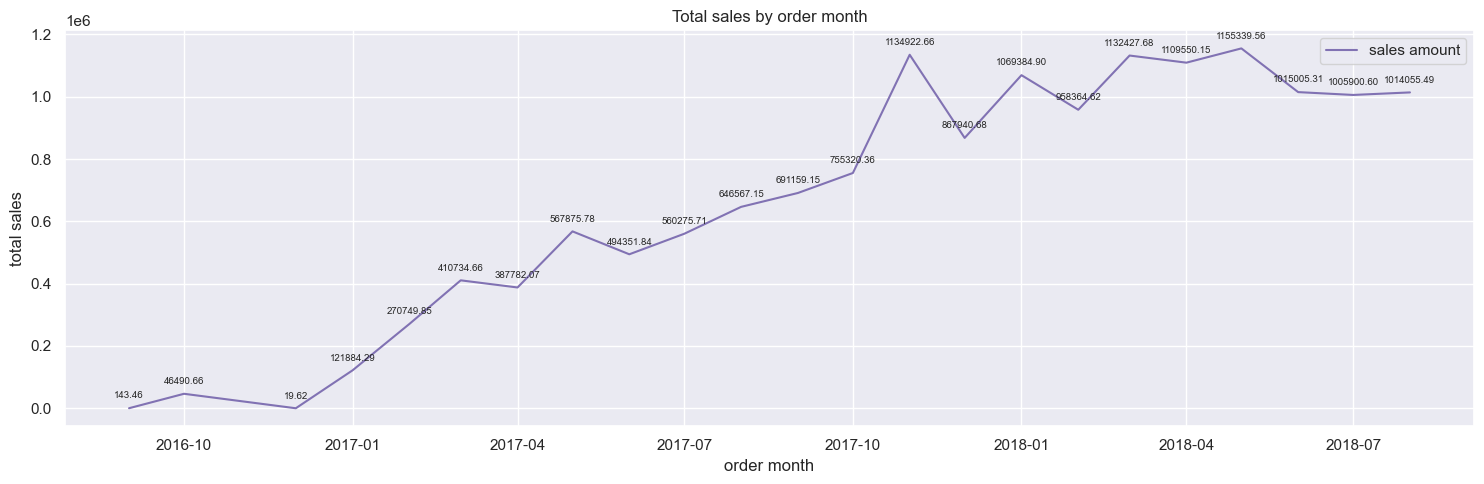

In [17]:
# configurando o plot
fig = plt.figure(figsize=(15, 5))
plt.plot(df_vendas_mes['order_month'], df_vendas_mes['total_sales'], color='m', label='sales amount')
plt.legend()
plt.xlabel('order month')
plt.ylabel('total sales')
plt.title('Total sales by order month')

# adicionando rótulos de valores no gráfico 

# zip para combinar x e y em pares ordenados e unpacking dos valores de x e y
for x, y in zip(df_vendas_mes['order_month'], df_vendas_mes['total_sales']):

    plt.annotate(text=f'{y:.2f}',               # o parametro 'text' recebe o valor para colocar nos rótulos (aqui estamos formatando y pra 2 casas decimais)
                 xy=(x, y),                     # parametro 'xy' recebe no formato de tupla o par ordenado (x, y) 
                 xytext=(0,7),                  # xytext representam as coordenadas onde o texto será posicionado. (0, y) representa y unidades acima do ponto 
                 textcoords='offset points',    # Offset, em pontos, do valor xy
                 ha='center',                   # alinhamento do texto
                 size=7                         # tamanho da fonte
            )
    
plt.tight_layout()
plt.show()


No geral, percebemos uma tendência de crescimento nas vendas da Olist. O mês que apresentou maior valor de vendas foi 05/2018

#### 2 - Quais são os produtos mais vendidos por categoria?
Como o dataset contém apenas os IDs dos produtos e as categorias, é mais interessante mostrarmos as categorias com os produtos mais caros neste caso

In [18]:
query2 = """
            WITH rkg_products_by_category AS (
                SELECT
                    ti.product_id,
                    tp.product_category_name,
                    ROUND(SUM(total_price), 2) AS total_price,
                    DENSE_RANK() OVER(PARTITION BY tp.product_category_name ORDER BY SUM(total_price) DESC) AS rkg_by_category -- rankeia os produtos dentro de cada categoria
                FROM table_order_items AS ti
                    JOIN table_products AS tp ON tp.product_id = ti.product_id
                GROUP BY 1, 2
            )
            SELECT
                product_id,
                product_category_name,
                total_price
            FROM rkg_products_by_category
            WHERE rkg_by_category = 1 -- filtra somente o primeiro produto de cada categ"""

df_produtos_por_categ = pd.read_sql(sql=query2, con=con)

# mostra o top 5 produtos e de quais categs eles sao
df_top_10 = df_produtos_por_categ.sort_values(by='total_price', ascending=False).head(10)
df_top_10

,product_id,product_category_name,total_price
11,bb50f2e236e5eea0100680137654686c,beleza_saude,67606.10
45,d1c427060a0f73f6b889a5c7c61f2ac4,informatica_acessorios,60976.03
13,99a4788cb24856965c36a24e339b6058,cama_mesa_banho,51071.60
62,d6160fb7873f184099d9bc95e30376af,pcs,50326.18
55,aca2eb7d00ea1a7b8ebd4e68314663af,moveis_decoracao,44820.76
26,5f504b3a1c75b73d6151be81eb05bdc9,cool_stuff,41725.81
9,25c38557cf793876c5abdd5931f922db,bebes,40311.95
67,53b36df67ebb7c41585e8d54d6772e08,relogios_presentes,39957.93
40,422879e10f46682990de24d770e7f83d,ferramentas_jardim,34201.26
43,5a848e4ab52fd5445cdc07aab1c40e48,geral,27286.05


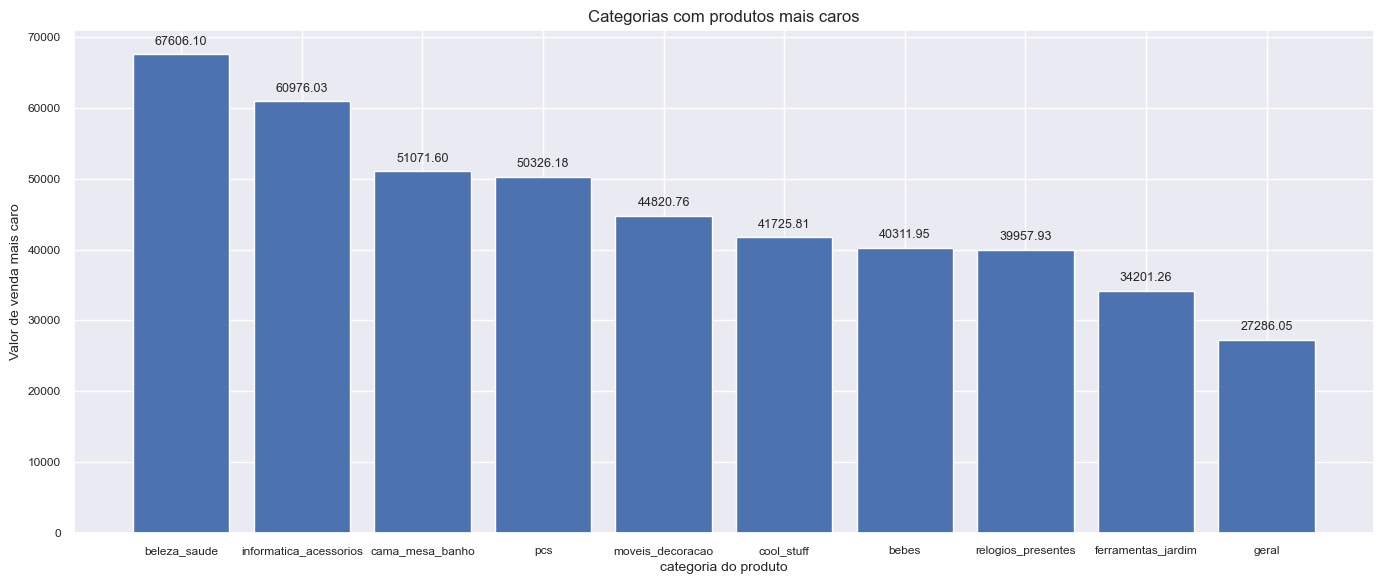

In [19]:
# plotando um gráfico de barras pra visualizar melhor o top 10 produtos

# criando os objetos fig e ax
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

# criando o plot
ax.bar(data=df_top_10, x='product_category_name', height='total_price', color='b')

# os parametros set_xlabel, set_ylabel e set_title possuem um argumento fontsize que permite o ajuste do tamanho das fontes
ax.set_xlabel('categoria do produto', fontsize=10)
ax.set_ylabel('Valor de venda mais caro', fontsize=10)
ax.set_title('Categorias com produtos mais caros', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=8.6)           # ax.tick_params() permite alterar várias propriedades das marcacoes dos graficos, inclusive o tamanho da fonte

# exibindo os rótulos de dados
for x, y in zip(df_top_10['product_category_name'], df_top_10['total_price']):
    plt.annotate(
                text=f'{y:.2f}',
                xy=(x, y),
                xytext=(0,7),
                textcoords='offset points',
                ha='center',
                size=9
    )

plt.tight_layout()
plt.show()

Temos que o produto mais caro foi da categoria 'Beleza e Saude', com um preço de R$ 67.606,00

#### 3 - Qual é a distribuição geográfica das vendas (por estado, cidade)?

In [20]:
# 4 - Qual é a distribuição geográfica das vendas (por estado, cidade)?

query4 = """SELECT
                customer_state,
                COUNT(DISTINCT tord.order_id) AS order_qty,
                ROUND(SUM(total_price), 2) AS total_sales,
                ROUND(SUM(total_price) / COUNT(DISTINCT tord.order_id), 2) AS avg_ticket_price
            FROM table_customers AS tc
                JOIN table_orders AS tord ON tord.customer_id = tc.customer_id
                JOIN table_order_items AS ti ON ti.order_id = tord.order_id
            GROUP BY 1"""

# criando df
df_sales_by_state = pd.read_sql(sql=query4, con=con)
#.sort_values(by='total_sales', ascending=True)

df_sales_by_state.head()


,customer_state,order_qty,total_sales,avg_ticket_price
0,AC,80,19575.33,244.69
1,AL,397,94172.49,237.21
2,AM,145,27585.47,190.24
3,AP,67,16141.81,240.92
4,BA,3256,591137.81,181.55


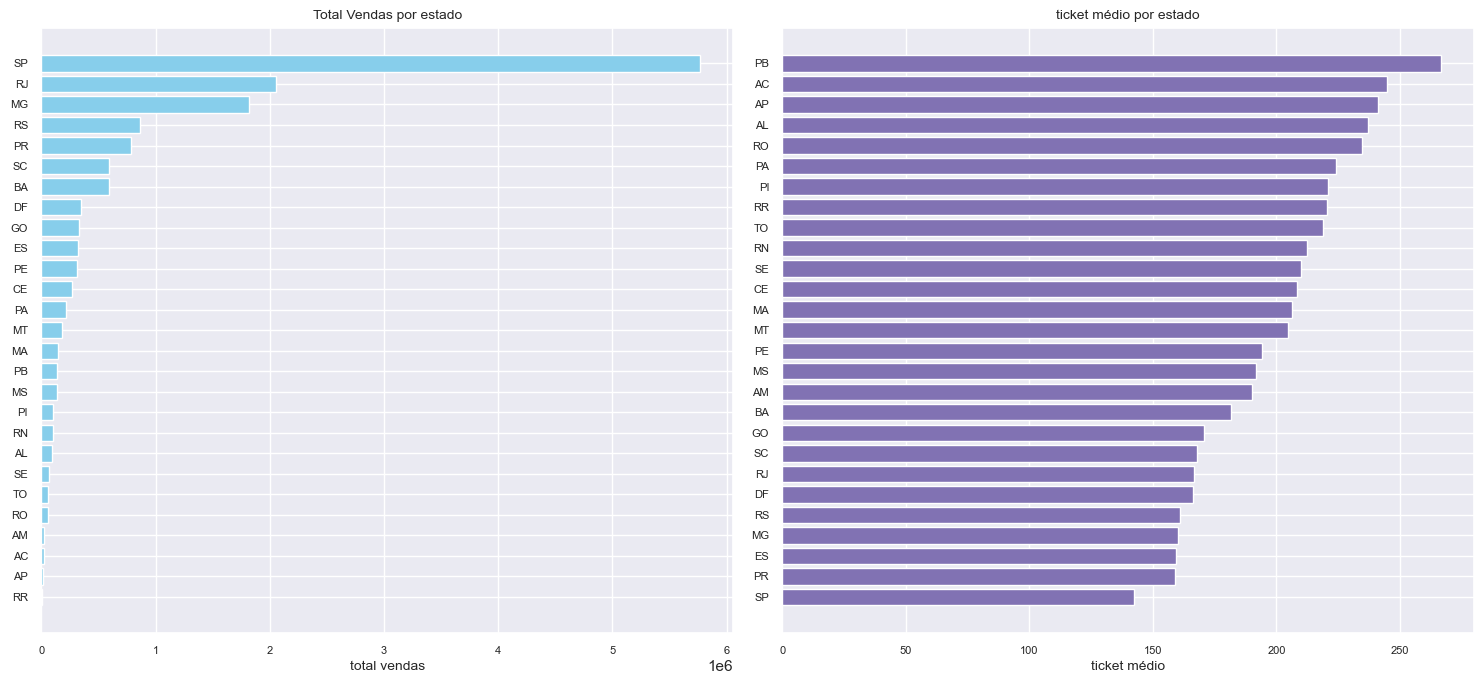

In [21]:
# criando objetos fig e axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# configurando o plot da esquerda
axes[0].barh(data=df_sales_by_state.sort_values(by='total_sales', ascending=True), y='customer_state', width='total_sales', color='skyblue')
axes[0].set_xlabel('total vendas', fontsize=10)
axes[0].set_title('Total Vendas por estado', fontsize=10)

# configurando o plot da direita
axes[1].barh(data=df_sales_by_state.sort_values(by='avg_ticket_price', ascending=True), y='customer_state', width='avg_ticket_price', color='m')
axes[1].set_xlabel('ticket médio', fontsize=10)
axes[1].set_title('ticket médio por estado', fontsize=10)

# ajustando o tamanho das labels x e y dos dois graficos

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

Analisando os dois gráficos acima podemos notar o seguinte comportamento: os estados da região sudeste apresentam maior valor total de vendas enquanto os estados das regiões Norte e Nordeste possuem um valor total de vendas menor. Entretanto, quando olhamos o ticket médio, há uma inversão: os estados da região Norte/Nordeste são os que apresentam maior ticket médio enquanto os estados do Sudeste estão entre os menores tickets. Isso indica que a população da região sudeste tende a fazer mais compras de menor valor ao passo que os moradores dos estados do Norte/Nordeste tendem a comprar menos em quantidade, porém suas compras são de valores mais altos.<br><br>Além disso, o estado de SP é o que posuiu maior representatividade nas vendas da Olist

Vamos ver agora para os 10 estados com maior valor de venda como as vendas se comportam ao longo do tempo

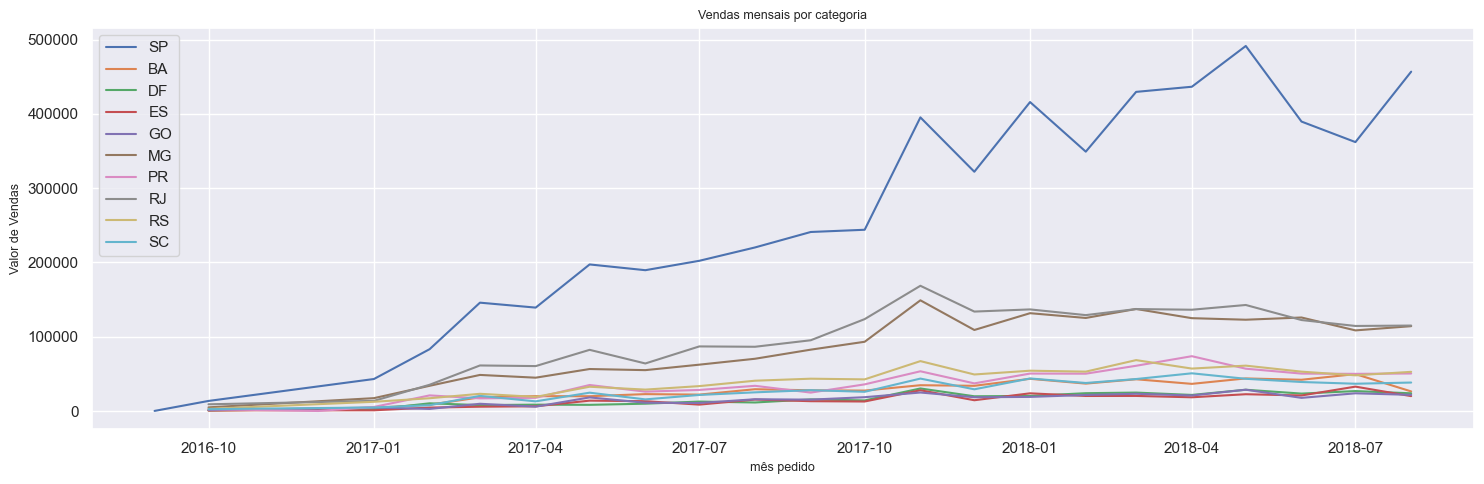

In [22]:
query5 = """WITH 
                ranking_vendas AS (
                    SELECT 
                        customer_state,
                        ROUND(SUM(total_price), 2) AS total_sales,
                        DENSE_RANK() OVER(ORDER BY SUM(total_price) DESC) AS rkg_vendas
                    FROM table_order_items AS ti
                        JOIN table_orders AS tords ON tords.order_id = ti.order_id
                        JOIN table_customers AS tc ON tc.customer_id = tords.customer_id
                    GROUP BY 1
                ),
                top_10 AS ( -- filtrando apenas as 10 UFs
                    SELECT
                        customer_state,
                        total_sales
                    FROM ranking_vendas
                    WHERE rkg_vendas <= 10
                )
            SELECT 
                DATE(order_approved_at, 'start of month') AS order_month,
                tc.customer_state,
                ROUND(SUM(total_price), 2) AS total_sales
            FROM table_order_items AS ti
                JOIN table_orders AS tords ON tords.order_id = ti.order_id
                JOIN table_customers AS tc ON tc.customer_id = tords.customer_id
                JOIN top_10 ON top_10.customer_state = tc.customer_state -- filtra apenas as 10 UFs com maior valor de venda
            GROUP BY 1, 2"""

# lendo o resultado da query pra um df
df_valor_por_uf_mes = pd.read_sql(sql=query5, con=con)

# ajustando order_month para datetime
df_valor_por_uf_mes['order_month'] = pd.to_datetime(df_valor_por_uf_mes['order_month'])

# configurando plot
fig = plt.figure(figsize=(15, 5))
sns.lineplot(data=df_valor_por_uf_mes, x='order_month', y='total_sales', hue='customer_state')
plt.legend()
plt.xlabel('mês pedido', fontsize=9)
plt.ylabel('Valor de Vendas', fontsize=9)
plt.title('Vendas mensais por categoria', fontsize=9)

plt.tight_layout()
plt.show()

Podemos ver que o estado de SP apresenta um maior crescimento. Em seguida, RJ e MG possuem curvas parecidas ao longo do tempo e também cresceram, mesmo que de forma mais atenuada em relação à SP. Já para os demais estados, temos um crescimento bem menor. Isso complementa o que vimos no gráfico acima: as vendas da Olist se concentram principalmente no eixo SP-RJ-MG

Vamos verificar se essa concentração de pedidos apresenta alguma correlação com os scores de avaliação dos pedidos

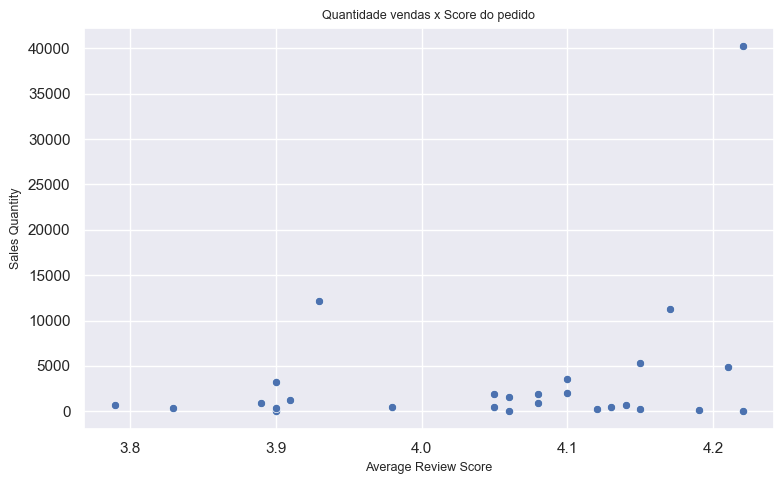

In [23]:
query6 = """SELECT 
                tc.customer_state,
                COUNT(DISTINCT ti.order_id) AS order_qty,
                ROUND(SUM(total_price), 2) AS total_sales,
                ROUND(AVG(review_score), 2) AS avg_score
            FROM table_order_items AS ti
                JOIN table_orders AS tords ON tords.order_id = ti.order_id
                JOIN table_customers AS tc ON tc.customer_id = tords.customer_id
                JOIN table_order_reviews AS trvw ON trvw.order_id = tords.order_id
            GROUP BY 1"""

df_score_por_estado = pd.read_sql(sql=query6, con=con)

# fazendo um scatter plot pra entender se pode existir alguma correlacao entre os scores dos pedidos e a quantidade de pedidos por estado
fig = plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_score_por_estado, x='avg_score', y='order_qty')
plt.xlabel('Average Review Score', fontsize=9)
plt.ylabel('Sales Quantity', fontsize=9)
plt.title('Quantidade vendas x Score do pedido', fontsize=9)

plt.tight_layout()
plt.show()

Pelo gráfico acima, vemos que não existe uma correlação entre a quantidade de vendas por estado e o score médio, já que a maioria dos estados que apresentam scores superiores à 4 apresentam quantidades de compras próximas de estados com scores médios menores (abaixo de 4).   

Vamos verificar quem são os estados que detém maior percentual de representatividade nos valores de vendas, por meio de uma regra de Pareto

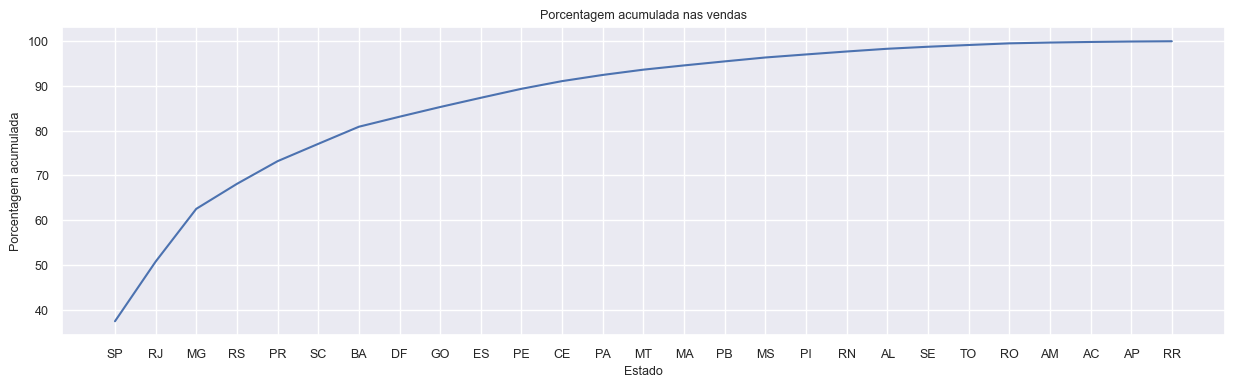

In [24]:
query7 = """WITH state_sales AS (
                SELECT
                    customer_state,
                    ROUND(SUM(total_price), 2) AS sales_by_state
                FROM table_customers AS tc
                    JOIN table_orders AS tord ON tord.customer_id = tc.customer_id
                    JOIN table_order_items
                    AS ti ON ti.order_id = tord.order_id
                GROUP BY 1
            )
            SELECT *,
                SUM(sales_by_state) OVER() AS total_sales, -- total geral de vendas
                SUM(sales_by_state) OVER(ORDER BY sales_by_state DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS rolling_sales, -- acumulado,
                --ROUND(sales_by_state * 100 / SUM(sales_by_state) OVER(), 2) AS pct_of_total,
                ROUND(SUM(sales_by_state) OVER(ORDER BY sales_by_state DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) * 100 / SUM(sales_by_state) OVER(), 2) AS rolling_pct
            FROM state_sales"""

df_pct_acumulada = pd.read_sql(sql=query7, con=con)

plt.figure(figsize=(15,4))
sns.lineplot(data=df_pct_acumulada, x='customer_state', y='rolling_pct')
plt.xlabel('Estado', fontsize=9)
plt.ylabel('Porcentagem acumulada', fontsize=9)
plt.title('Porcentagem acumulada nas vendas', fontsize=9)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.show()

Vemos acima que o eixo SP-RJ-MG representa 60% do total de vendas da Olist. Além disso, 07 estados (27%) são responsáveis por aproxidamente 80% das vendas

#### 5 - Qual é o tempo médio de entrega dos pedidos?
Vamos começar primeiro obtendo a média geral. A data usada como referência é a data de compra pelo consumidor, já que em alguns casos, a aprovação pode demorar mais de 1 dia para ser feita.

In [25]:
query8 = """SELECT -- media geral 
                AVG(
                    CAST(julianday(order_estimated_delivery_date) - julianday(order_purchase_timestamp) AS INTEGER)
                ) AS avg_estimated_delivery_days,
                AVG(
                    CAST(julianday(order_delivered_customer_date) - julianday(order_purchase_timestamp) AS INTEGER)
                ) AS avg_act_delivery_days
            FROM table_orders"""

df_avg_geral = pd.read_sql(sql=query8, con=con)

# arredondando pra duas casas decimais
df_avg_geral.apply(lambda x: round(x, 2), axis=1)

,avg_estimated_delivery_days,avg_act_delivery_days
0,23.37,12.09


A média de dias ESTIMADOS para entrega (diferença entre order_estimated_delivery_date e order_purchase_timestamp) é de cerca de 23 dias. Já a média que se observa na PRÁTICA (isto é, a diferença entre order_delivered_customer_date e order_purchase_timestamp) é de aproximadamente 12 dias.

Calculando agora algumas estatísticas sobre as datas de compra e entrega

In [26]:
query9 = """SELECT -- media por categoria de produto
                product_category_name,
                CAST(julianday(order_estimated_delivery_date) - julianday(order_purchase_timestamp) AS INTEGER) AS estimated_delivery_days,
                CAST(julianday(order_delivered_customer_date) - julianday(order_purchase_timestamp) AS INTEGER) AS act_delivery_days
            FROM table_orders AS tord
                JOIN table_order_items AS ti ON ti.order_id = tord.order_id
                JOIN table_products AS tp ON tp.product_id = ti.product_id """

df_dias_por_categ = pd.read_sql(sql=query9, con=con)

# estatisticas das colunas de dias entre as datas e excluindo a estatistica de count fazendo o slicing do df
df_dias_por_categ.describe().iloc[1:]

,estimated_delivery_days,act_delivery_days
mean,23.415292,12.030278
std,8.778817,9.531694
min,2.000000,0.000000
25%,18.000000,6.000000
50%,23.000000,10.000000
75%,28.000000,15.000000
max,155.000000,209.000000


75% das vendas da Olist demoram menos de 15 dias para serem entregues

In [27]:
# coeficiente de variação: medida para nos ajudar a entender em porcentagem o quão disperso nossos dados estão ao redor da média

# como os nossos dados são de toda a 'populacao' de vendas da Olist, vamos usar o argumento 'ddof' (delta degrees of freedom) igual a 0 no metodo df.std() 
coef_variacao = round(df_dias_por_categ['act_delivery_days'].std(ddof=0) * 100 / df_dias_por_categ['act_delivery_days'].mean(), 2)
coef_variacao

79.23

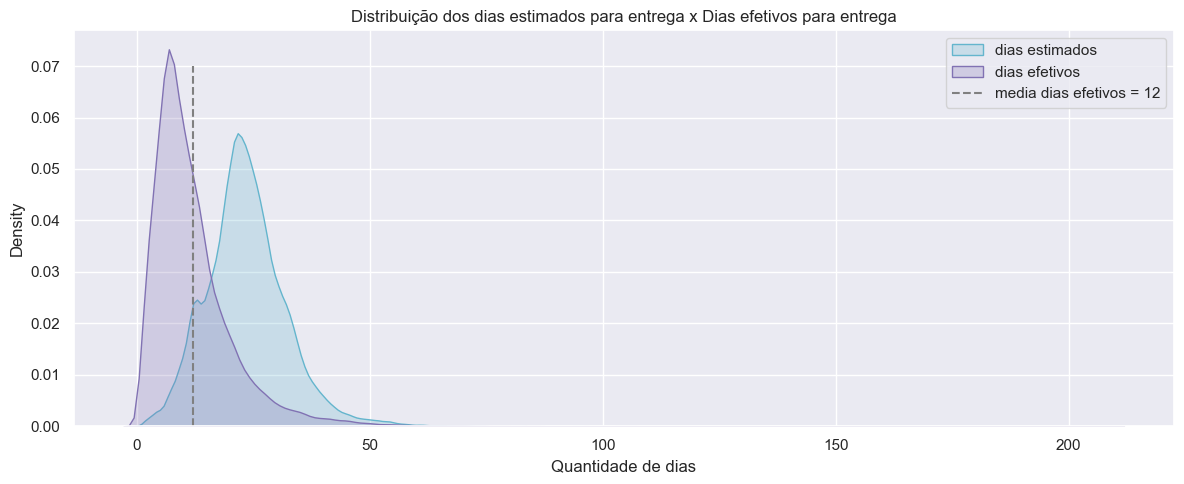

In [28]:
# plotando a distribuição dos dados para entendermos o perfil
media_dias_efetivos = df_dias_por_categ['act_delivery_days'].mean() # calculo da media para plotar ela na distribuicao

# dimensionamento do plot
fig = plt.figure(figsize=(12,5))

# sobreposicao dos plots
sns.kdeplot(df_dias_por_categ['estimated_delivery_days'], color='c', fill=True)
sns.kdeplot(df_dias_por_categ['act_delivery_days'], color='m', fill=True)
plt.vlines(x=media_dias_efetivos, colors='gray', linestyles='--', ymin=0, ymax=0.07)

# configuracoes do plot
plt.legend(labels=['dias estimados', 'dias efetivos', f'media dias efetivos = {round(media_dias_efetivos)}'])
plt.xlabel('Quantidade de dias')
plt.title('Distribuição dos dias estimados para entrega x Dias efetivos para entrega')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Box plot dos dias de entrega dos pedidos')

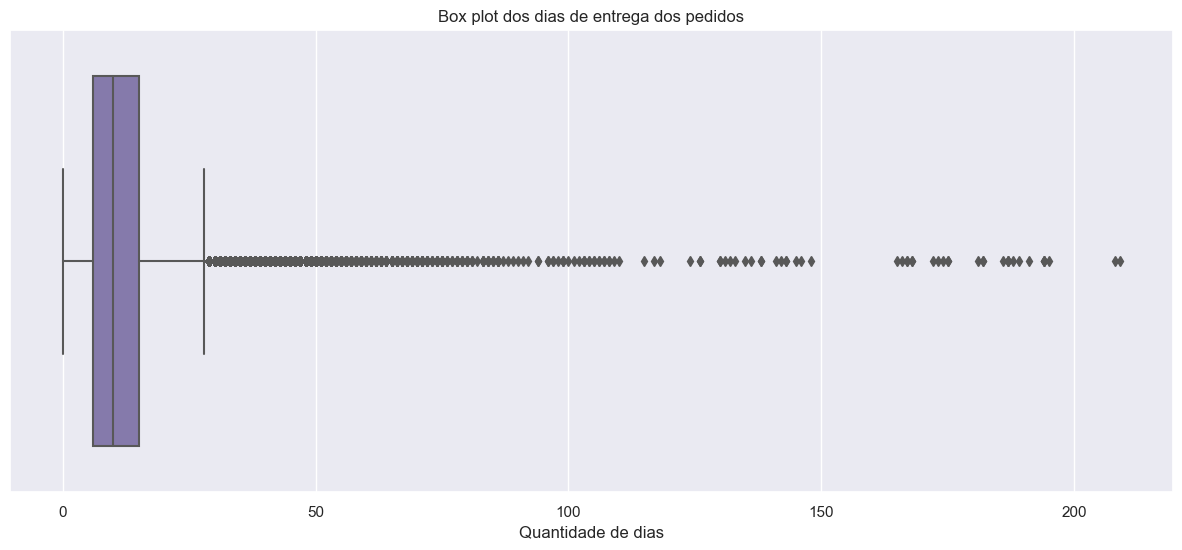

In [29]:
plt.figure(figsize=(15,6))
sns.boxplot(data=df_dias_por_categ, x='act_delivery_days', color='m')
plt.xlabel('Quantidade de dias')
plt.title('Box plot dos dias de entrega dos pedidos')

Podemos ver que os dias efetivos para entrega possuem uma distribuição assimétrica à direita, nos indicando a presença de outliers, que neste contexto significam que demoraram muitos dias para serem entregues, o que desloca nossa média do centro da distribuição. O boxplot confirma a presença de outliers.<br><br> Ainda, com o cálculo do coeficiente de variação, vemos que os dias efetivos para entrega tem uma variação média de 79% em torno da média, o que confirma que temos produtos da Olist que demoram vários dias para serem entregues e precisariam de atenção por parte da empresa. 

Vamos usar a regra do intervalo interquartilico para identificar as categorias que apresentam produtos entregues acima do limite superior. É de se esperar que as categorias de produtos que mais vendem, tendem a ter mais atrasos na entrega. Portanto, para fazer um comparativo mais justo, pegamos a quantidade de pedidos em atraso em relação ao total de categoria para ver o percentual de pedidos atrasados e adotamos como tolerância 10% dos pedidos atrasados. O que estiver acima disso, consideramos uma violação.

In [30]:
# limite_sup será usado como parametro dentro da nossa query
q1, q3 = df_dias_por_categ['act_delivery_days'].quantile(q=[.25, .75]) # 1º e 3º quartis
limite_sup = q3 + 1.5 * (q3 - q1) # limite superior para regra do intervalo interquatilico na deteccao de outliers

query10 = """WITH pedidos_atrasados AS (
                SELECT -- media por categoria de produto
                    product_category_name,
                    COUNT(DISTINCT ti.order_id) AS order_qty_later
                FROM table_orders AS tord
                    JOIN table_order_items AS ti ON ti.order_id = tord.order_id
                    JOIN table_products AS tp ON tp.product_id = ti.product_id
                WHERE CAST(julianday(order_delivered_customer_date) - julianday(order_purchase_timestamp) AS INTEGER) > @AAAA
                GROUP BY 1
            )
            SELECT
                tp.product_category_name,
                COUNT(DISTINCT order_id) AS order_qty,
                order_qty_later,
                ROUND(order_qty_later * 100 / COUNT(DISTINCT order_id), 2) AS pct_later_orders
            FROM table_order_items AS ti
                JOIN table_products AS tp ON tp.product_id = ti.product_id
                JOIN pedidos_atrasados patras ON patras.product_category_name = tp.product_category_name
            GROUP BY 1"""

df_pct_later_orders = pd.read_sql(sql=query10, con=con, params={'AAAA': limite_sup})\
                        .sort_values(by='pct_later_orders', ascending=False)\
                        .reset_index(drop=True)\
                        .query('pct_later_orders > 10') # filtra as categorias com mais de 10% de pedidos em atraso

df_pct_later_orders

,product_category_name,order_qty,order_qty_later,pct_later_orders
0,moveis_escritorio,1273,201,15.0
1,fashion_roupa_infanto_juvenil,8,1,12.0
2,casa_conforto_2,24,3,12.0


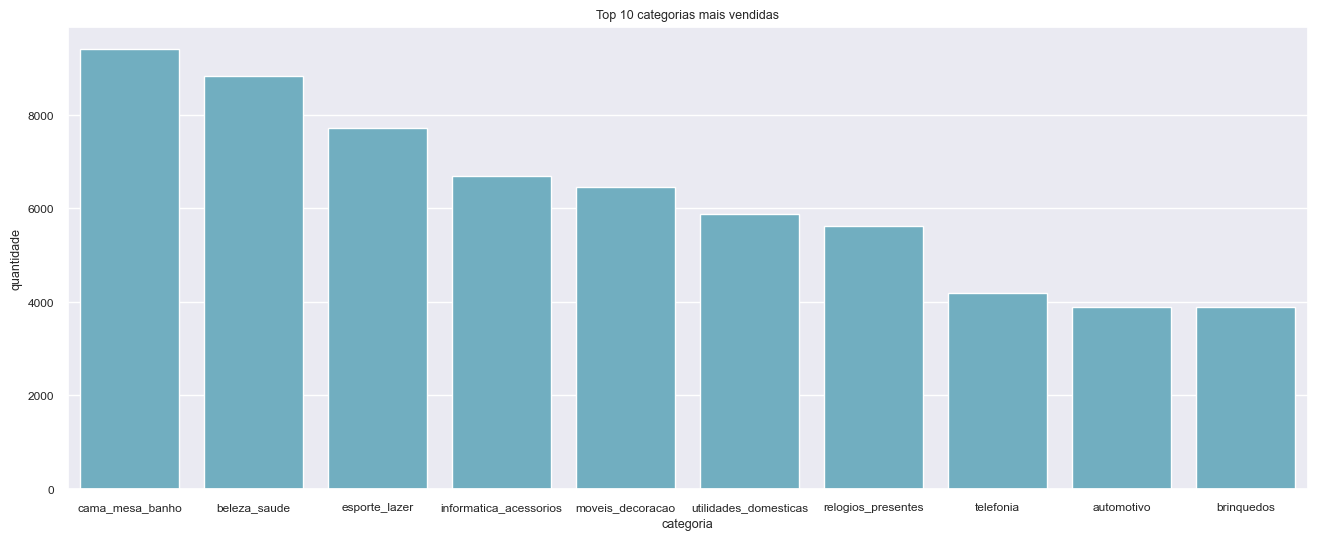

In [31]:
# verificando quantidade de pedidos por categoria
query11 = """SELECT
                product_category_name,
                COUNT(DISTINCT order_id) AS order_qty
            FROM table_order_items AS ti
                JOIN table_products AS tp ON tp.product_id = ti.product_id
            GROUP BY 1"""

df_orders_por_categ = pd.read_sql(sql=query11, con=con)\
                        .sort_values(by='order_qty', ascending=False)\
                        .reset_index(drop=True)\
                        .head(10)

# plotando um grafico de barras
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

sns.barplot(data=df_orders_por_categ, x='product_category_name', y='order_qty', color='c')
ax.set_title('Top 10 categorias mais vendidas', fontsize=9)
ax.set_xlabel('categoria', fontsize=9)
ax.set_ylabel('quantidade', fontsize=9)
ax.tick_params(axis='both', which='both', labelsize=8.6)
plt.show()

Dentro do limite de 10% de pedidos com entrega em atraso, as categorias que ultrapassam esse limite são 'moveis_escritorio', 'fashion_roupa_infanto_juvenil' e 'casa_conforto_2' 

#### Avaliando os scores dos pedidos

Quais as categorias melhor e pior avaliadas?

Considerando apenas categorias de produtos com mais de 1000 vendas

In [32]:
# top 5 melhores produtos avaliados com mais de 1000 pedidos

query13 = """SELECT
                product_category_name,
                ROUND(AVG(review_score), 2) AS avg_score,
                COUNT(DISTINCT ti.order_id) AS order_qty,
                ROUND(AVG(CAST(julianday(order_delivered_customer_date) - julianday(order_purchase_timestamp) AS INTEGER)), 2) AS avg_act_delivery_days
            FROM table_order_items AS ti 
                JOIN table_products AS tp ON tp.product_id = ti.product_id
                JOIN table_order_reviews AS rvw ON rvw.order_id = ti.order_id
                JOIN table_orders AS tords ON tords.order_id = ti.order_id
            GROUP BY 1
            HAVING order_qty > 1000 -- filtra apenas as categs com mais de 1000 pedidos"""

df_melhores_score_categ = pd.read_sql(sql=query13, con=con)\
                   .sort_values(by='avg_score', ascending=False)\
                   .reset_index(drop=True)\
                   .head(5) # pega apenas o top 5

df_melhores_score_categ[['product_category_name', 'avg_score', 'order_qty']]



,product_category_name,avg_score,order_qty
0,malas_acessorios,4.37,1015
1,papelaria,4.28,2251
2,pet_shop,4.24,1680
3,perfumaria,4.24,3076
4,brinquedos,4.23,3773


In [33]:
# pega o top 5 piores scores de categorias com mais de 1000 pedidos
df_piores_scores = pd.read_sql(sql=query13, con=con)\
                     .sort_values(by='avg_score')\
                     .reset_index(drop=True)\
                     .head() # top 5

df_piores_scores[['product_category_name', 'avg_score', 'order_qty']]

,product_category_name,avg_score,order_qty
0,moveis_escritorio,3.62,1244
1,cama_mesa_banho,3.94,9176
2,geral,4.00,1381
3,moveis_decoracao,4.03,6256
4,telefonia,4.03,4068


A categoria 'moveis_escritorio' é a que apresenta pior score nos reviews, mesmo apresentando menor quantidade de pedidos em relação às demais categorias do top 5 piores scores

Verificando agora se as notas dos reviews tem alguma correlação com a quantidade de dias de atraso do pedido 

Text(0, 0.5, 'score')

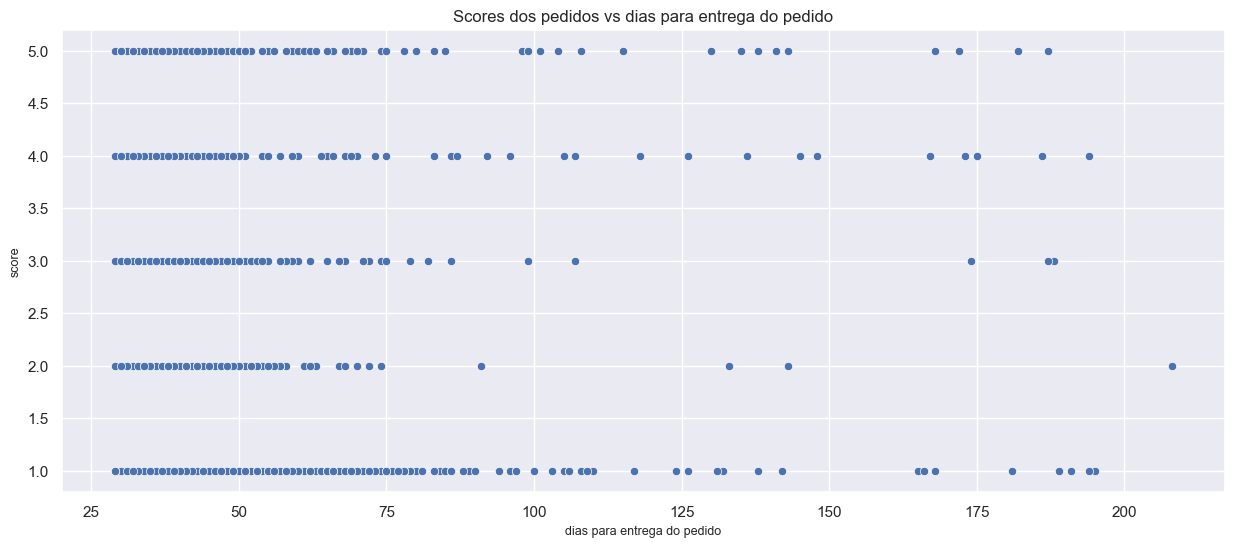

In [42]:
query14 = """SELECT
                tords.order_id,
                review_score AS avg_score,
                CAST(julianday(order_delivered_customer_date) - julianday(order_purchase_timestamp) AS INTEGER) AS delivery_days_later
             FROM table_orders AS tords
                JOIN table_order_reviews AS rvw ON (
                rvw.order_id = tords.order_id
                --AND order_delivered_customer_date > order_estimated_delivery_date
                AND CAST(julianday(order_delivered_customer_date) - julianday(order_purchase_timestamp) AS INTEGER) > @AAAA
                )"""

df_atrasos_scores = pd.read_sql(sql=query14, con=con, params={'AAAA': limite_sup})

# plotando um scatterplot
plt.figure(figsize=(15, 6))
sns.scatterplot(data=df_atrasos_scores, x='delivery_days_later', y='avg_score')
plt.title('Scores dos pedidos vs dias para entrega do pedido')
plt.xlabel('dias para entrega do pedido', fontsize=9)
plt.ylabel('score', fontsize=9)

Para os pedidos cujos dias para entrega ultrapassaram o limite superior, não vemos uma correlação entre os dias de entrega e os scores dos pedidos 

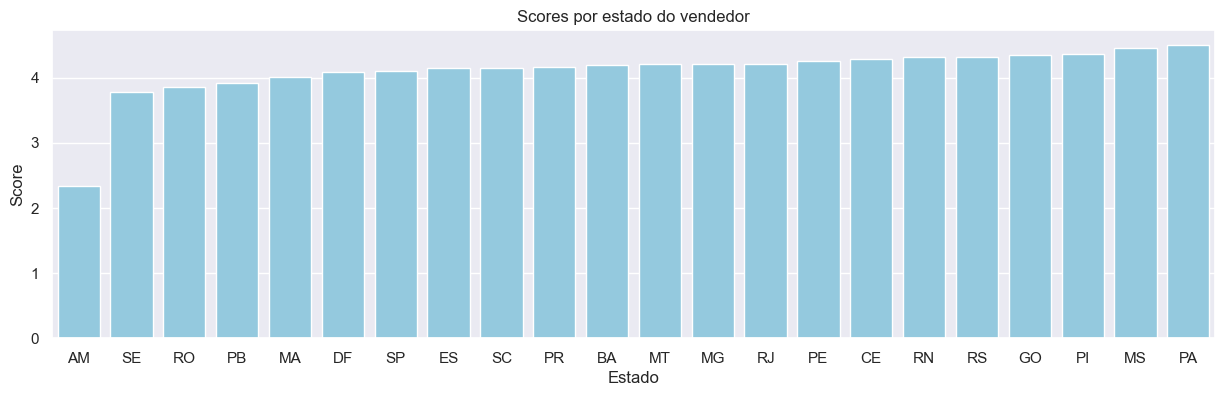

In [50]:
query15 = """SELECT
                ti.order_id,
                ti.seller_id,
                tords.customer_id,
                seller_city,
                seller_state,
                customer_city,
                customer_state,
                CASE 
                    WHEN customer_state != seller_state THEN 'estados diferentes'
                    ELSE 'mesmo estado'
                END AS flag_dif_states,
                review_score,
                review_comment_message,
                CAST(julianday(order_delivered_customer_date) - julianday(order_purchase_timestamp) AS INTEGER) AS delivery_days
            FROM table_order_items AS ti 
                JOIN table_sellers AS ts ON ts.seller_id = ti.seller_id
                JOIN table_orders AS tords ON tords.order_id = ti.order_id
                JOIN table_customers AS tc ON tc.customer_id = tords.customer_id
                JOIN table_order_reviews AS rvw ON rvw.order_id = ti.order_id"""

# agrupando os dados
df_score_by_seller_state = pd.read_sql(sql=query15, con=con)\
                             .groupby(by='seller_state')['review_score'].mean()\
                             .reset_index()\
                             .rename(columns={'review_score': 'avg_score'})\
                             .sort_values(by='avg_score')

# plot 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))
sns.barplot(data=df_score_by_seller_state, x='seller_state', y='avg_score', color='skyblue')
ax.set_title('Scores por estado do vendedor')
ax.set_xlabel('Estado')
ax.set_ylabel('Score')
plt.show()

#### Avaliando os scores quando o estado do vendedor é igual ou diferente do estado do consumidor

In [51]:
df_scores_por_flag = pd.read_sql(sql=query15, con=con)\
                       .groupby(by='flag_dif_states')['review_score'].mean()\
                       .reset_index()

df_scores_por_flag

,flag_dif_states,review_score
0,estados diferentes,4.063282
1,mesmo estado,4.236488


In [35]:
# encerrando conexao com o bd
cur.close()
con.close()